There are 9 hardware shift position, in each hardware position shift there are 3 repetitions. In this approach, we train and test each hardware position shift seperately. In each hardware software shift we use 3 fold validation, train 2 repetitions and test the rest repetition. 
Noted: In training we only use virtual shifting in Self-supervised learning for better accuracy
We only consider 5 motions: 1Flexion, 2Extension, 7Open, 8close, 9rest

1. Define necessary modules, class, functions

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from data_loader import CustomSignalData, CustomSignalData1
from torch.autograd import Variable
from encoder import Encoder as E
from helpers import set_cmd_cb, rms_formuula, get_data, get_all_data, get_shift_data, get_operators, plot_cfs_mat, roll_data

DEVICE = torch.device("cpu")
def getFeatureMatrix(rawDataMatrix, windowLength, windowOverlap):
    rms = lambda sig: np.sqrt(np.mean(sig**2))
    nChannels,nSamples = rawDataMatrix.shape    
    I = int(np.floor(nSamples/(windowLength-windowOverlap)))
    featMatrix = np.zeros([nChannels, I])
    for channel in range(nChannels):
        for i in range (I):
            wdwStrtIdx=i*(windowLength-windowOverlap)
            sigWin = rawDataMatrix[channel][wdwStrtIdx:(wdwStrtIdx+windowLength-1)] 
            featMatrix[channel, i] = rms(sigWin)
    featMatrixData = np.array(featMatrix)
    return featMatrixData

class FFNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(FFNN, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inputSize, 9, bias=False),
            torch.nn.Sigmoid()
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(9, outputSize, bias=False),
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, x, encoder=None):
        if not encoder:
            encoder = self.encoder
        z = encoder(x)
        class_z = self.classifer(z)

        return class_z

class Operator(nn.Module):
    def __init__(self, in_features, n_rotations):
        super(Operator, self).__init__()
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.core = torch.nn.Parameter(torch.zeros(3*self.in_features**2)- 0*torch.diag(torch.rand(3*self.in_features**2)/10))
        self.core.requires_grad = True
        self.n_rotations = n_rotations
        
    def rotate_batch(self, x, d, out_features):
      rotated = torch.empty(x.shape[0], 3*out_features*out_features, device=DEVICE)
      phies = [torch.linalg.matrix_power(self.core,i).to(DEVICE) for i in range (0,self.n_rotations+0)]
      for i in range (x.shape[0]):
        rotated[i] = phies[(d[i]+0)%4].matmul(x[i]) 
      return rotated

    def forward(self, x, d):
        """
        Args:
          x of shape (batch_size, 3, xsize, xsize): Inputs.
        
        Returns:
          y of shape (batch_size, 3*xsize^2): Outputs.
        """
        z = self.rotate_batch(x, d, self.in_features)
        return z
def get_tensor(arr):
    return torch.tensor(arr, device=DEVICE,dtype=torch.float )

def rotate_batch(x, d, out_features):
    M = torch.diag(torch.ones(8)).roll(-1,1)
    used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)]
    rotated = torch.empty(x.shape, device=DEVICE)
    for i in range (x.shape[0]):
        rotated[i] = used_bases[d[i]].matmul(x[i]) 
    return rotated

def clf_acc(model, loader, masks = None, encoder = None):
    model.eval()
    correct = 0
    iter = 0
    with torch.no_grad():
        for inputs, labels,_,_ in loader:
            inputs = inputs.to(DEVICE)
            if masks is not None:
                inputs = inputs * masks[:inputs.size()[0]]
            labels = labels.to(DEVICE)
            labels = labels.flatten()
            if encoder:
                pred = model(inputs, encoder)
            else:
                pred = model(inputs)
            correct += (1-torch.abs(torch.sign(torch.argmax(pred,dim = 1)- labels))).mean().item()
            iter += 1
    return correct/iter

def compute_accuracy(a, b, loader):
    a.eval()
    b.eval()
    
    correct = 0
    iter = 0
    
    with torch.no_grad():
        for inputs1, inputs2, shift1, shift2, labels, _ in loader:
            inputs1 = inputs1.to(DEVICE)
            inputs2 = inputs2.to(DEVICE)
            shift1 = -shift1.int().flatten().to(DEVICE)
            shift2 = -shift2.int().flatten().to(DEVICE)
            labels = labels.flatten().to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y1 = a(inputs1)
            y_tr_est1 = rotate_batch(y1,shift1,6)
            y_tr1 = b(y_tr_est1)

            y2 = a(inputs2)
            y_tr_est2 = rotate_batch(y2,shift1,6)
            y_tr2 = b(y_tr_est2)

            correct += (1-torch.abs(torch.sign(torch.argmax(y_tr1,dim = 1)- labels))).mean().item() + \
                    (1-torch.abs(torch.sign(torch.argmax(y_tr2,dim = 1)- labels))).mean().item()
            iter += 1
    return correct * 0.5 / iter

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2. Train and Test at the same physical position shifting itself: 3 fold validation

In [2]:
subject = '26'

Fs = 1000
windowLength = int(np.floor(0.1*Fs))  #160ms
windowOverlap =  int(np.floor(50/100 * windowLength))

X_train = [[np.zeros([0, 8]) for _ in range(3)] for _ in range(9)]
y_train = [[np.zeros([0]) for _ in range(3)] for _ in range(9)]
X_test = [[np.zeros([0, 8]) for _ in range(3)] for _ in range(9)]
y_test = [[np.zeros([0]) for _ in range(3)] for _ in range(9)]


for k_fold in range(0, 3): 
    for shift in range(0,9): 
        for files in sorted(os.listdir(f'Subject_{subject}/Shift_{shift}/')):
            _, class_,_, rep_ = files.split('_')

            if class_ in ['1','2','7','8','9']:
                df = pd.read_csv(f'Subject_{subject}/Shift_{shift}/{files}',skiprows=0,sep=' ',header=None)
                data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
                data_arr -= 121
                data_arr /= 255.0
                feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
                
                if not class_.startswith('9'):
                    rms_feature = feaData.sum(0)
                    baseline = 2*rms_feature[-50:].mean()
                    start_ = np.argmax(rms_feature[::1]>baseline)
                    end_  = -np.argmax(rms_feature[::-1]>baseline)
                    feaData = feaData.T[start_:end_]
                else:
                    feaData = feaData.T
                
                
                if rep_.startswith(str(k_fold+1)):
                    X_test[shift][k_fold] = np.concatenate([X_test[shift][k_fold],feaData])
                    y_test[shift][k_fold] = np.concatenate([y_test[shift][k_fold],np.ones_like(feaData)[:,0]*int(class_)-1])
                else:
                    X_train[shift][k_fold] = np.concatenate([X_train[shift][k_fold],feaData])
                    y_train[shift][k_fold] = np.concatenate([y_train[shift][k_fold],np.ones_like(feaData)[:,0]*int(class_)-1])



In [5]:
print("Training dataset feature:")
print(X_train[1][0].shape)
print("Training dataset label:")
print(y_train[1][0].shape)
print("Testing dataset feature:")
print(X_test[1][0].shape)
print("Testing dataset label:")
print(y_test[1][0].shape)

Training dataset feature:
(2773, 8)
Training dataset label:
(2773,)
Testing dataset feature:
(1366, 8)
Testing dataset label:
(1366,)


2.2 Logistic Regression:

2.2.1: Training leanring model

In [6]:
for shift in range(9):
    for k_fold in range(3):
        reg = LogisticRegression(penalty='l2', C=100).fit(X_train[shift][k_fold], y_train[shift][k_fold])
        dump(reg, f'LogisticRegression_fold_{k_fold+1}_shift_{shift}_app1_5motions.joblib')

/home/eea-10/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.2.2 Testing accuracy

In [7]:
accuracies_LosReg_list = [[0 for _ in range(3)] for _ in range(9)]
for shift in range(9):
    for k_fold in range(3):
        logRegres  = load(f'LogisticRegression_fold_{k_fold+1}_shift_{shift}_app1_5motions.joblib')
        accuracy = logRegres.score(X_test[shift][k_fold],y_test[shift][k_fold])
        accuracies_LosReg_list[shift][k_fold]= accuracy
        print(f'Accuracy of shift {shift} fold {k_fold+1}:')
        print(accuracy)

Accuracy of shift 0 fold 1:
0.9789397240377633
Accuracy of shift 0 fold 2:
0.9815905743740795
Accuracy of shift 0 fold 3:
0.9447236180904522
Accuracy of shift 1 fold 1:
0.9648609077598829
Accuracy of shift 1 fold 2:
0.8590747330960854
Accuracy of shift 1 fold 3:
0.9612573099415205
Accuracy of shift 2 fold 1:
0.9762258543833581
Accuracy of shift 2 fold 2:
0.9703264094955489
Accuracy of shift 2 fold 3:
0.9804216867469879
Accuracy of shift 3 fold 1:
0.9833962264150944
Accuracy of shift 3 fold 2:
0.9759398496240601
Accuracy of shift 3 fold 3:
0.9750755287009063
Accuracy of shift 4 fold 1:
0.9913589945011784
Accuracy of shift 4 fold 2:
0.9822940723633564
Accuracy of shift 4 fold 3:
0.9645550527903469
Accuracy of shift 5 fold 1:
0.9746646795827124
Accuracy of shift 5 fold 2:
0.9720382634289919
Accuracy of shift 5 fold 3:
0.9828741623231572
Accuracy of shift 6 fold 1:
0.9809596344249809
Accuracy of shift 6 fold 2:
0.993841416474211
Accuracy of shift 6 fold 3:
0.9931558935361217
Accuracy of sh

In [8]:
print(accuracies_LosReg_list)

[[0.9789397240377633, 0.9815905743740795, 0.9447236180904522], [0.9648609077598829, 0.8590747330960854, 0.9612573099415205], [0.9762258543833581, 0.9703264094955489, 0.9804216867469879], [0.9833962264150944, 0.9759398496240601, 0.9750755287009063], [0.9913589945011784, 0.9822940723633564, 0.9645550527903469], [0.9746646795827124, 0.9720382634289919, 0.9828741623231572], [0.9809596344249809, 0.993841416474211, 0.9931558935361217], [0.9706325301204819, 0.9673832468495182, 0.9821029082774049], [0.9700822737471952, 0.9815809669992326, 0.9931766489764974]]


In [9]:
average_accuracies_LosReg_list = []
for accuracy in accuracies_LosReg_list:
    average_accuracies_LosReg_list.append(sum(accuracy)/3)

In [10]:
print(average_accuracies_LosReg_list)

[0.9684179721674316, 0.9283976502658297, 0.9756579835419649, 0.9781372015800202, 0.9794027065516273, 0.9765257017782872, 0.9893189814784379, 0.9733728950824684, 0.9816132965743084]


In [11]:
value_average_accuracies_LosReg = sum(average_accuracies_LosReg_list) / 9 
print(value_average_accuracies_LosReg)

0.9723160432244862


2.2.3.2 Confusion matrix in each 9 hardwrae shifts between 9 classes

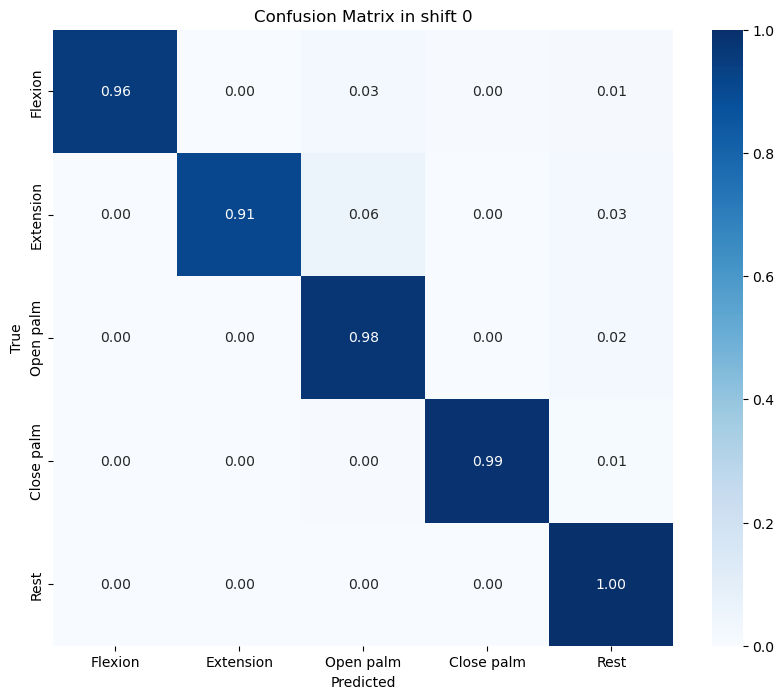

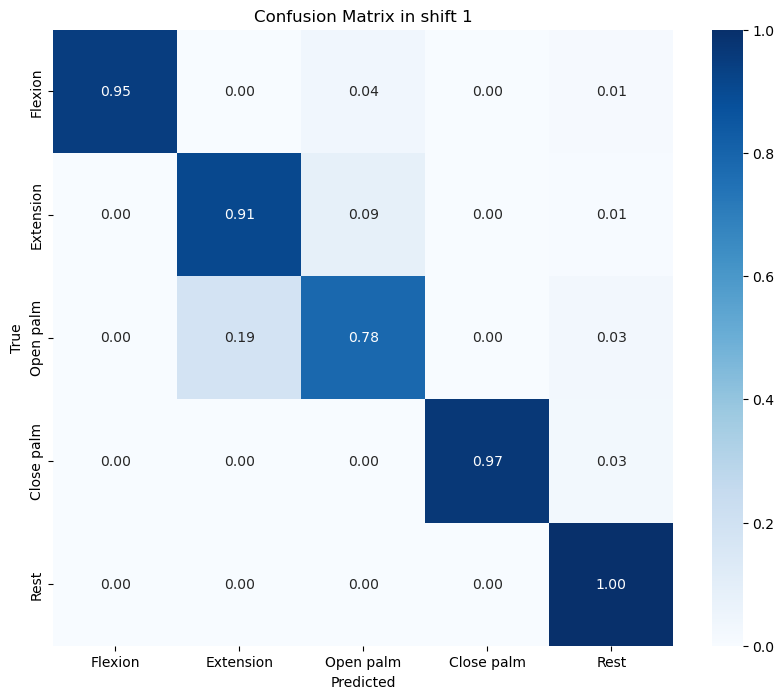

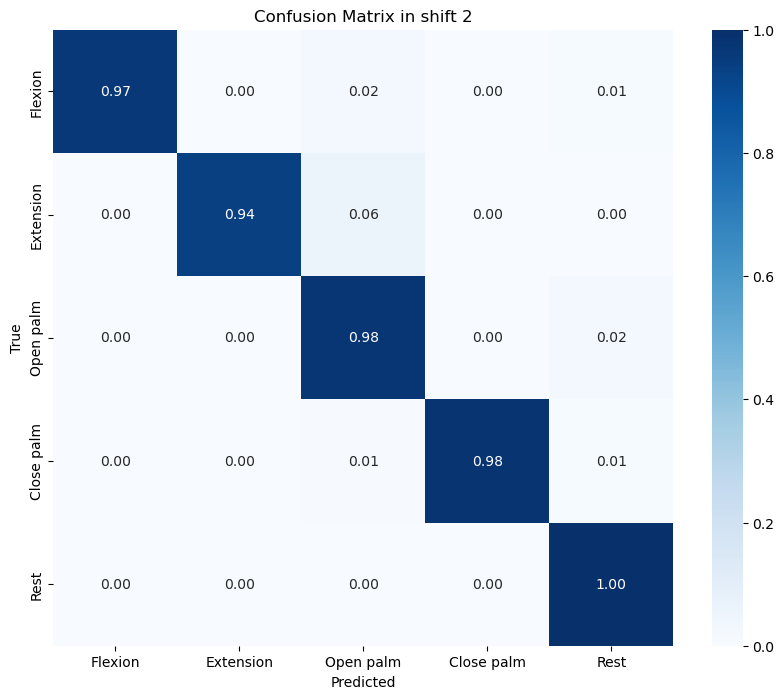

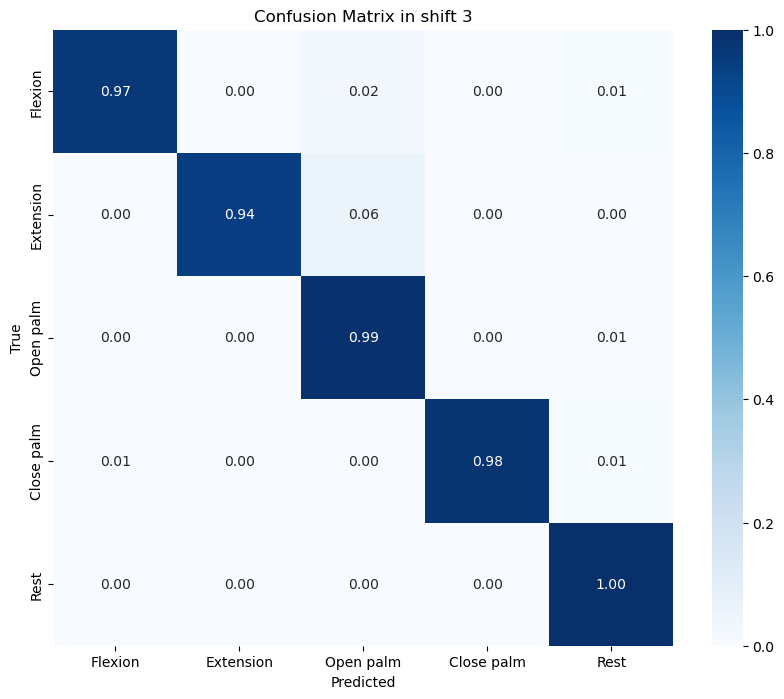

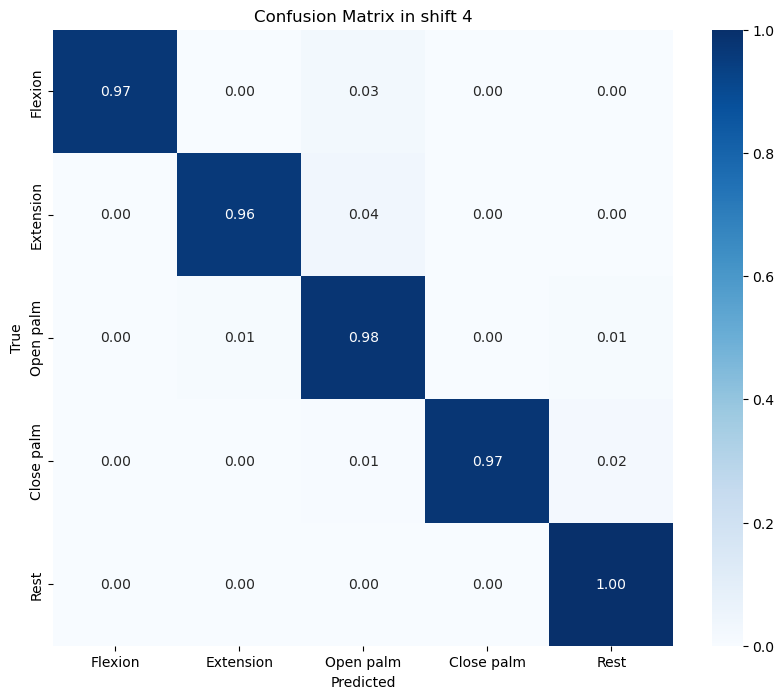

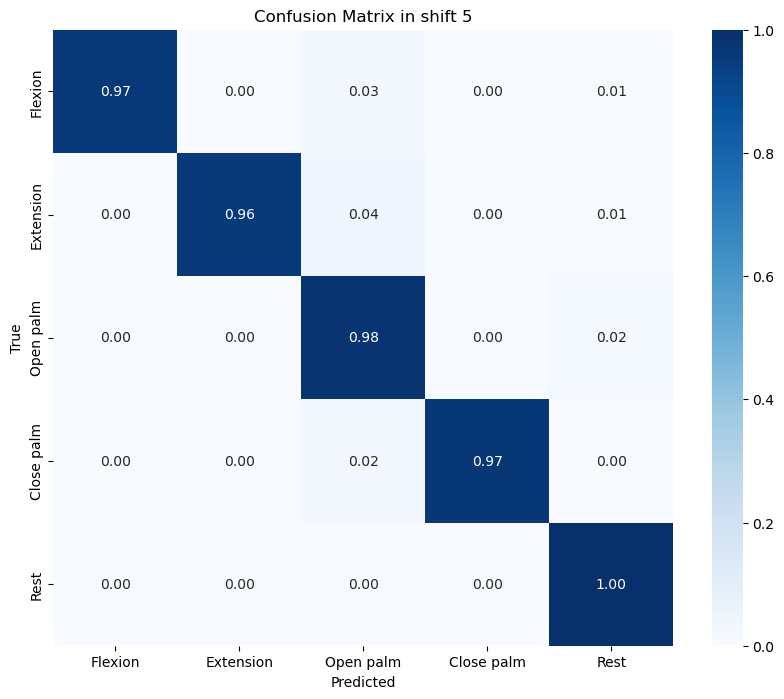

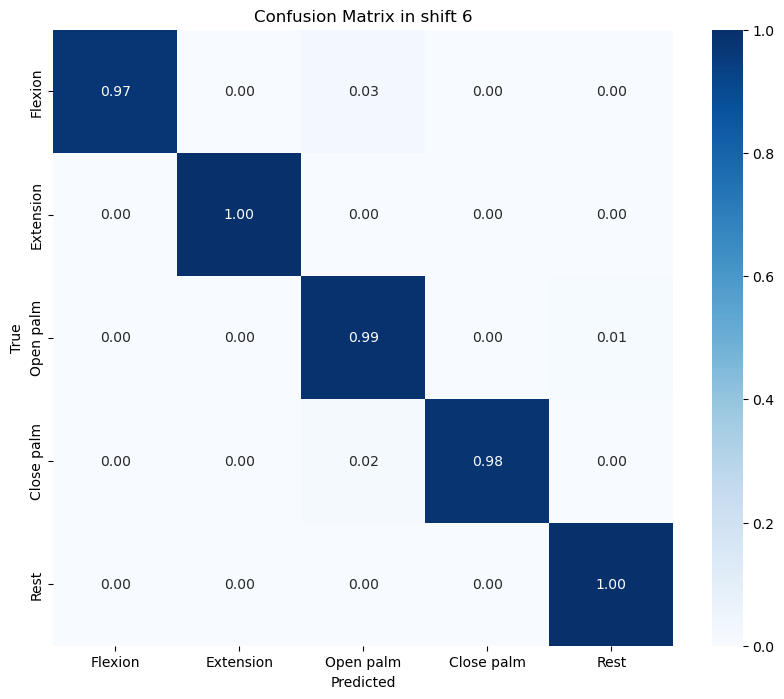

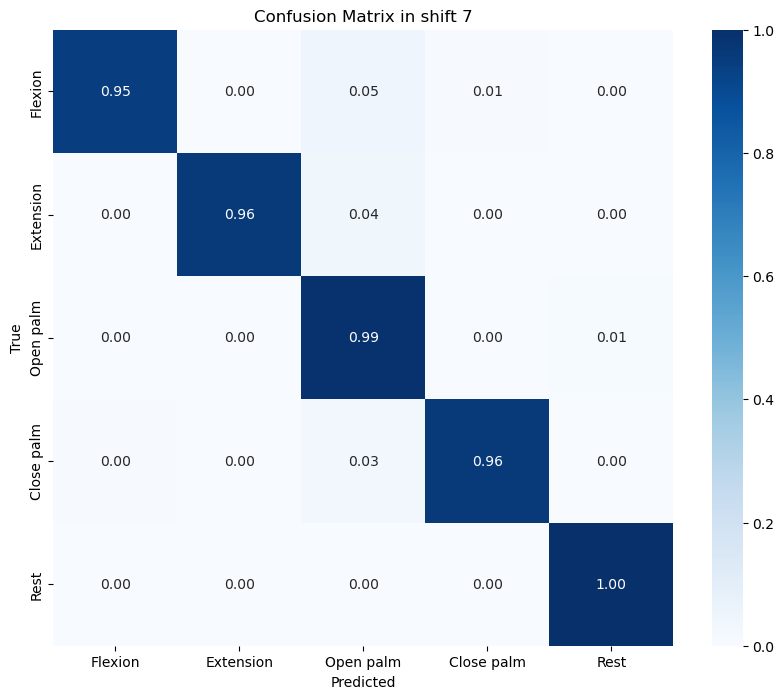

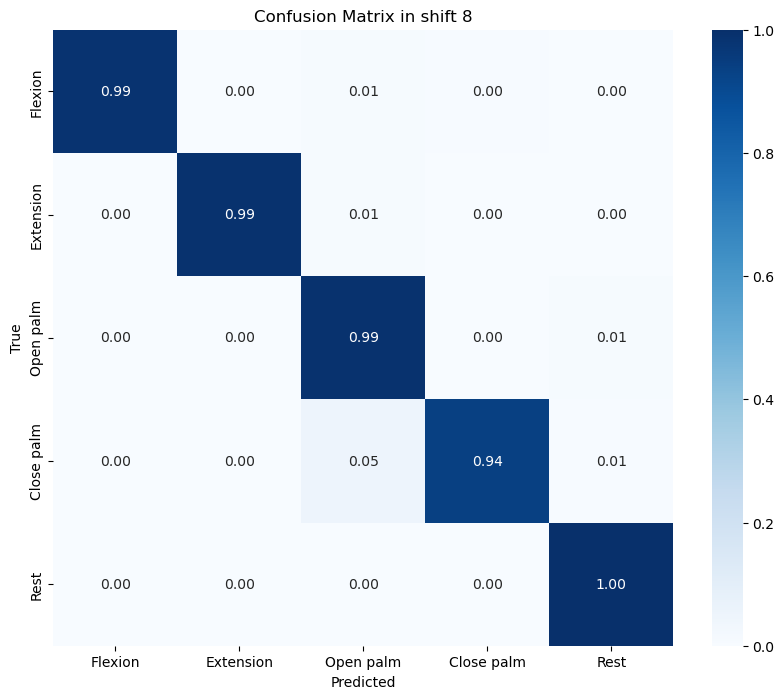

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define class names
class_names = ['Flexion', 'Extension', 'Open palm', 'Close palm', 'Rest']

conf_matrices_LogReg_list = []

# Loop through shifts and folds
for shift in range(9):
    all_predictions = []
    all_true_labels = []
    for k_fold in range(3):
        # Load the trained model
        reg = load(f'LogisticRegression_fold_{k_fold+1}_shift_{shift}_app1_5motions.joblib')
        # Make predictions on the test data
        predictions = reg.predict(X_test[shift][k_fold])
        # Accumulate predictions and true labels
        all_predictions.extend(predictions)
        all_true_labels.extend(y_test[shift][k_fold])
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)
    conf_matrices_LogReg_list.append(conf_matrix)
    
    # Convert confusion matrix from counts to percentages
    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix in shift {shift}')
    plt.show()



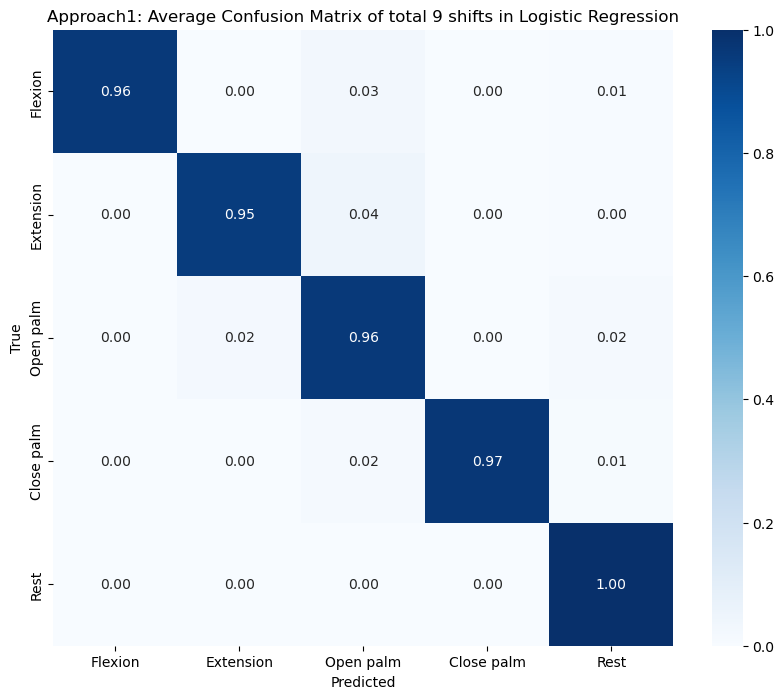

In [4]:
average_conf_matrix_LogReg = np.mean(conf_matrices_LogReg_list, axis=0)
average_total_LogReg_samples_per_class = np.sum(average_conf_matrix_LogReg, axis=1)
average_conf_LogReg_matrix_percent = average_conf_matrix_LogReg / average_total_LogReg_samples_per_class[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(average_conf_LogReg_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Approach1: Average Confusion Matrix of total 9 shifts in Logistic Regression')
plt.show()

2.3 Feed Forward Neural Network

2.3.1 Simulated data for training for Feed Forward Neural Network

In [16]:
alltrainloader_list = [[] for _ in range(9)]

for shift in range(9):
    for k_fold in range(3):
        all_train_dataset = CustomSignalData(get_tensor(X_train[shift][k_fold]), get_tensor(y_train[shift][k_fold]))
        alltrainloader = torch.utils.data.DataLoader(all_train_dataset, batch_size = 102, shuffle=True)
        alltrainloader_list[shift].append(alltrainloader)

for alltrainloader in alltrainloader_list:
    print(alltrainloader)

[<torch.utils.data.dataloader.DataLoader object at 0x7fe229c0e6e0>, <torch.utils.data.dataloader.DataLoader object at 0x7fe229328790>, <torch.utils.data.dataloader.DataLoader object at 0x7fe229a40a60>]
[<torch.utils.data.dataloader.DataLoader object at 0x7fe31c5ba350>, <torch.utils.data.dataloader.DataLoader object at 0x7fe31c5b82e0>, <torch.utils.data.dataloader.DataLoader object at 0x7fe31c5ba8c0>]
[<torch.utils.data.dataloader.DataLoader object at 0x7fe22968bfa0>, <torch.utils.data.dataloader.DataLoader object at 0x7fe31c5bcca0>, <torch.utils.data.dataloader.DataLoader object at 0x7fe31c5bc6d0>]
[<torch.utils.data.dataloader.DataLoader object at 0x7fe31c5be7a0>, <torch.utils.data.dataloader.DataLoader object at 0x7fe31c5bc460>, <torch.utils.data.dataloader.DataLoader object at 0x7fe31c5be230>]
[<torch.utils.data.dataloader.DataLoader object at 0x7fe22995c100>, <torch.utils.data.dataloader.DataLoader object at 0x7fe229ea9180>, <torch.utils.data.dataloader.DataLoader object at 0x7fe22

2.3.2 Training Feed Forward Neural Network

In [17]:
inputDim = 8     # takes variable 'x' 
outputDim = 9      # takes variable 'y'
learningRate = 0.005

for shift in range(9):
    for k_fold in range(3):
        model = FFNN(inputDim, outputDim)
        model = model.to(DEVICE)

        crit = torch.nn.CrossEntropyLoss()
        acc_record = []
        params_clf = list(model.parameters())# + list(encoder.parameters())
        optim = torch.optim.Adam(params_clf, lr=learningRate)

        epochs = 200
        #encoder = encoder.to(device)
        for epoch in range(epochs):
            model.train()

            # Converting inputs and labels to Variable
            for inputs, labels, _, _ in alltrainloader_list[shift][k_fold]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                labels = labels.long()
                labels = labels.flatten()
                outputs = model(inputs, None)
                optim.zero_grad()
                # get loss for the predicted output
                losss = crit(outputs, labels) #+ 0.001 * model.l1_regula()
                # get gradients w.r.t to parameters
                losss.backward()
                # update parameters
                optim.step()

        torch.save(model.state_dict(), f"modelwoOperator_fold_{k_fold+1}_shift_{shift}_app1_5motions.pt")


2.3.3 Testing accuracy of Feed Forward Neural Network

2.3.3.1 Accuracy of each 9 hardware shift with 3 accuracies in each represnt for 3 folds

In [18]:
accuracies_FFNN_list = [[0 for _ in range(3)] for _ in range(9)]
for shift in range(9):
    for k_fold in range(3):
        modelWOoperator = FFNN(8,9)
        modelWOoperator.load_state_dict(torch.load(f"modelwoOperator_fold_{k_fold+1}_shift_{shift}_app1_5motions.pt")) # loaded from the file: parameters learned during training.
        modelWOoperator.eval()

        test_shift_dataset = CustomSignalData(get_tensor(X_test[shift][k_fold]), get_tensor(y_test[shift][k_fold]))
        testshiftloader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)
        accuracies_FFNN_list[shift][k_fold] = clf_acc(modelWOoperator, testshiftloader, encoder = None)

for accuracy in accuracies_FFNN_list:
    print(accuracy)

[0.9806034421098644, 0.9824561351223996, 0.925141243611352]
[0.9722222173423097, 0.9521946907043457, 0.9678362524300291]
[0.9744151987527546, 0.9831871296230116, 0.9836309456399509]
[0.9888392825211797, 0.9851190415876252, 0.9717261844447681]
[0.9961419734689925, 0.9893939343365756, 0.9724702324186053]
[0.9902597357119832, 0.9744152018898412, 0.954548390848296]
[0.9924242388118397, 0.9984848477623679, 0.9939393910494718]
[0.979910708963871, 0.9780701702101189, 0.9857568006430354]
[0.9813988070402827, 0.9856060548262162, 0.9969696955247359]


In [19]:
average_accuracies_FFNN = []
for accuracy in accuracies_FFNN_list:
    average_accuracies_FFNN.append(sum(accuracy)/3)

print(average_accuracies_FFNN)

[0.962733606947872, 0.9640843868255615, 0.9804110913385724, 0.9818948361845243, 0.9860020467413911, 0.9730744428167069, 0.9949494925412266, 0.9812458932723418, 0.9879915191304116]


In [20]:
value_average_accuracies_FFNN = sum(average_accuracies_FFNN) / 9 
print(value_average_accuracies_FFNN)

0.9791541461998455


2.3.4.2 Confusion matrix in each 9 hardwrae shifts between 9 classes

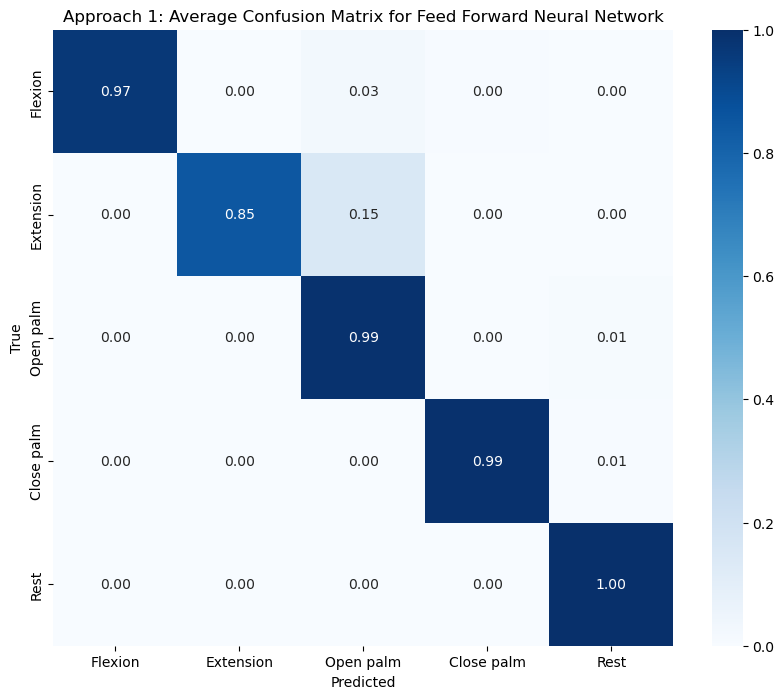

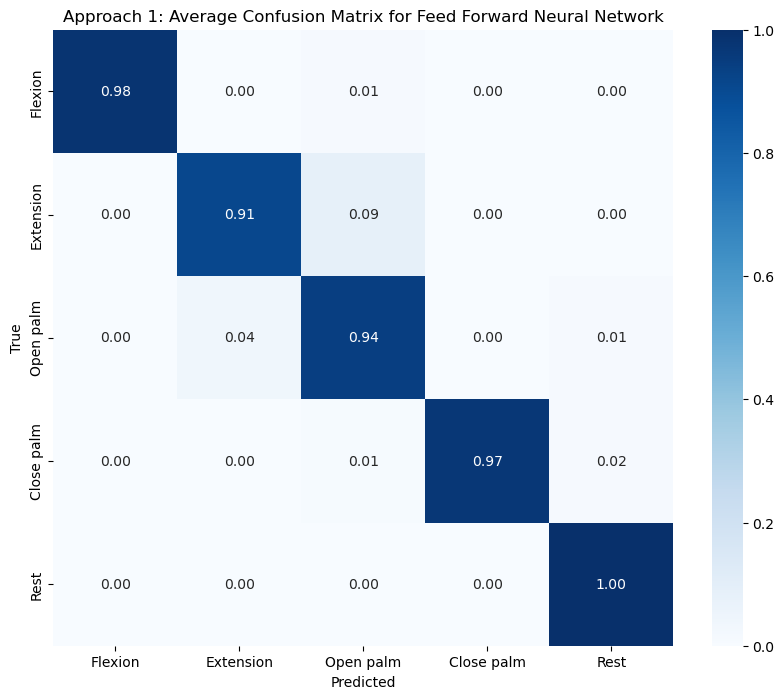

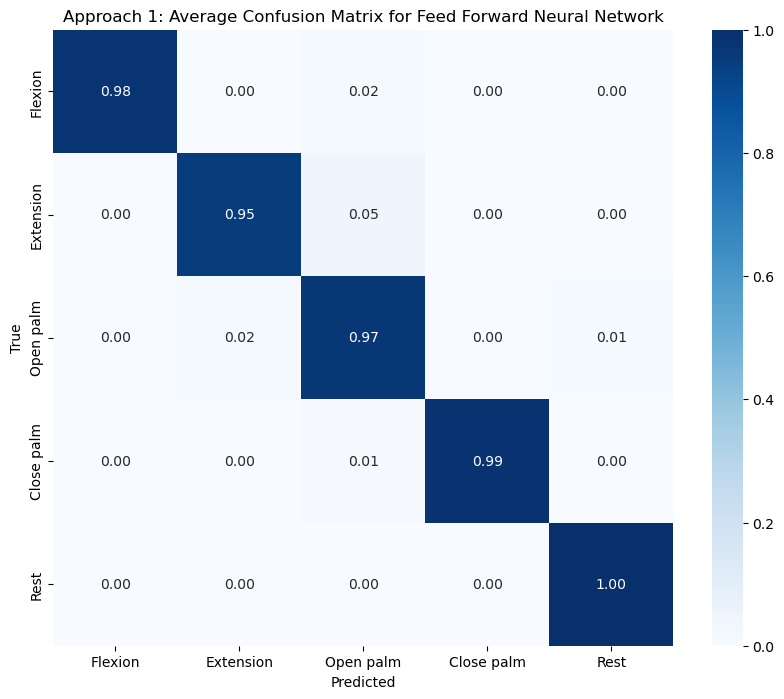

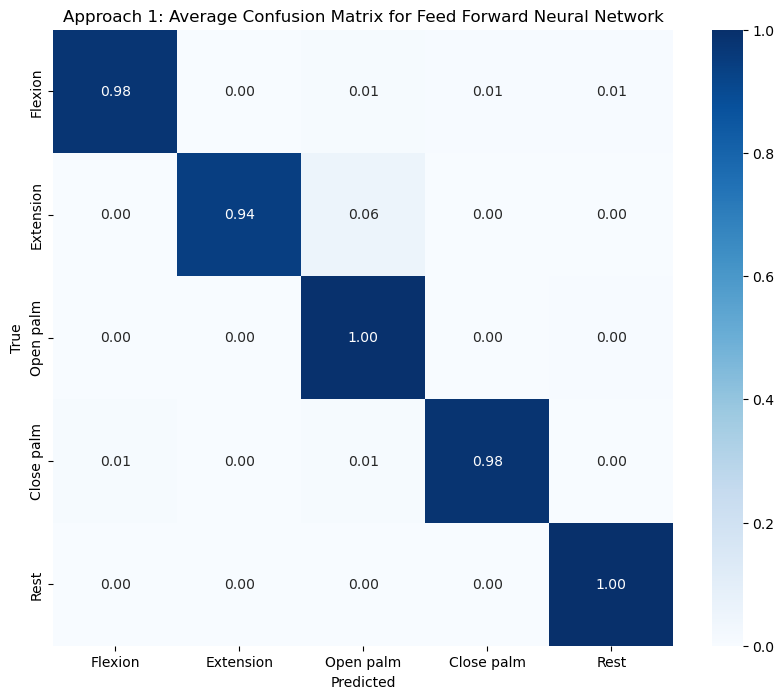

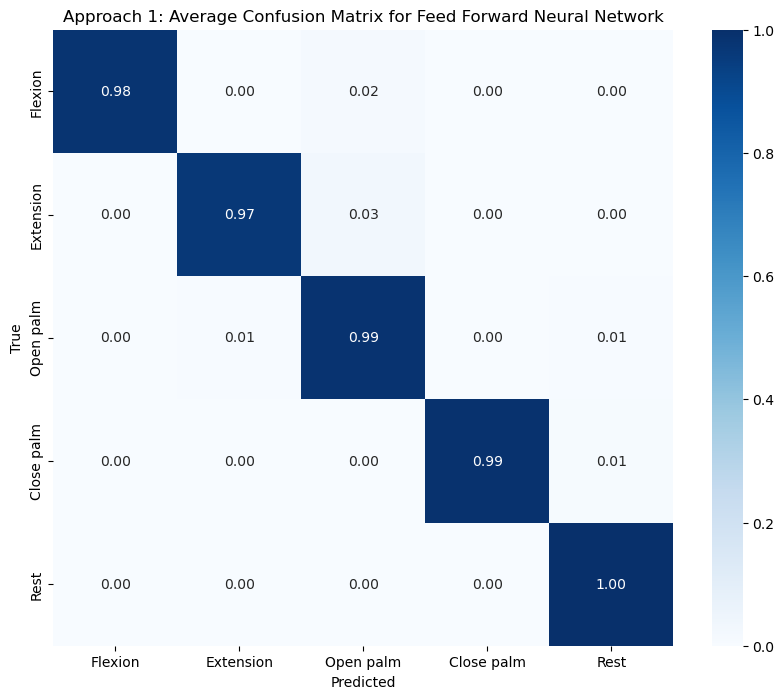

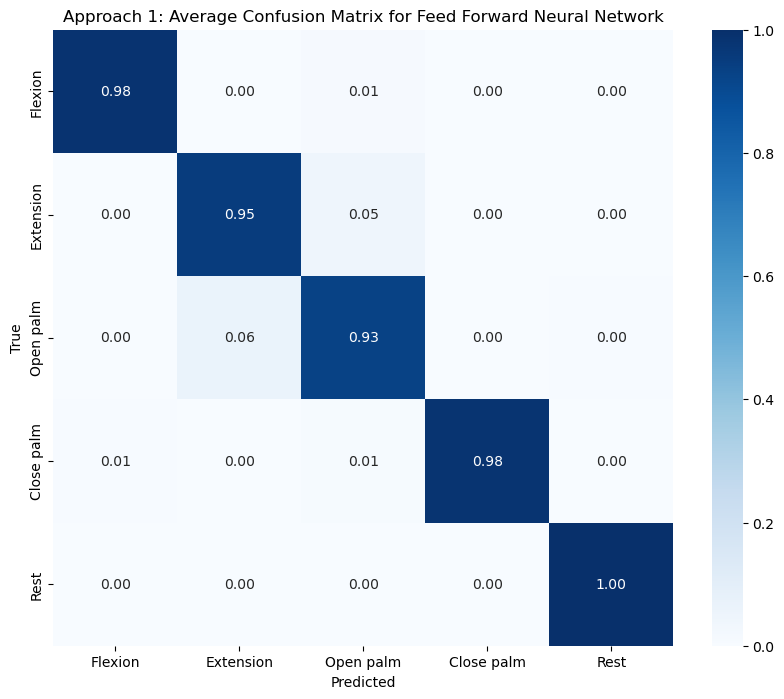

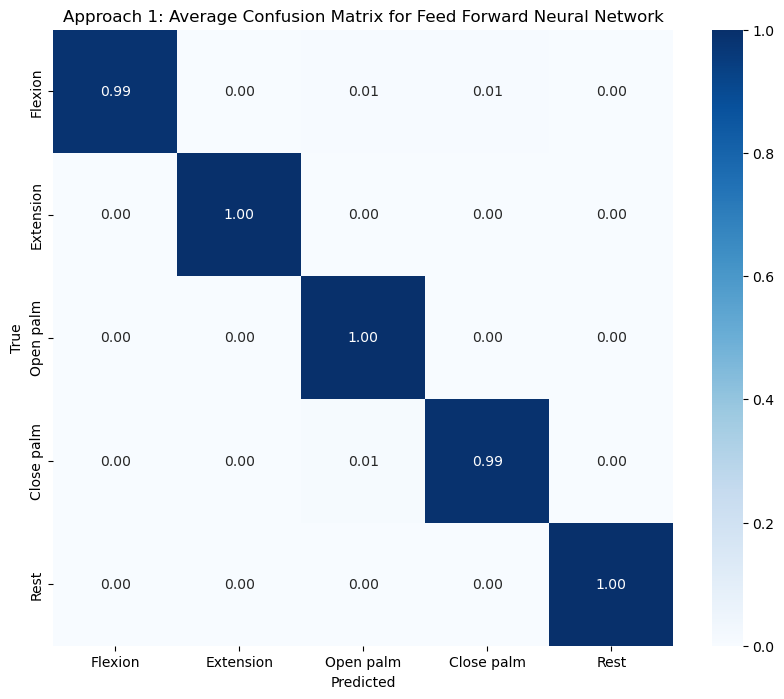

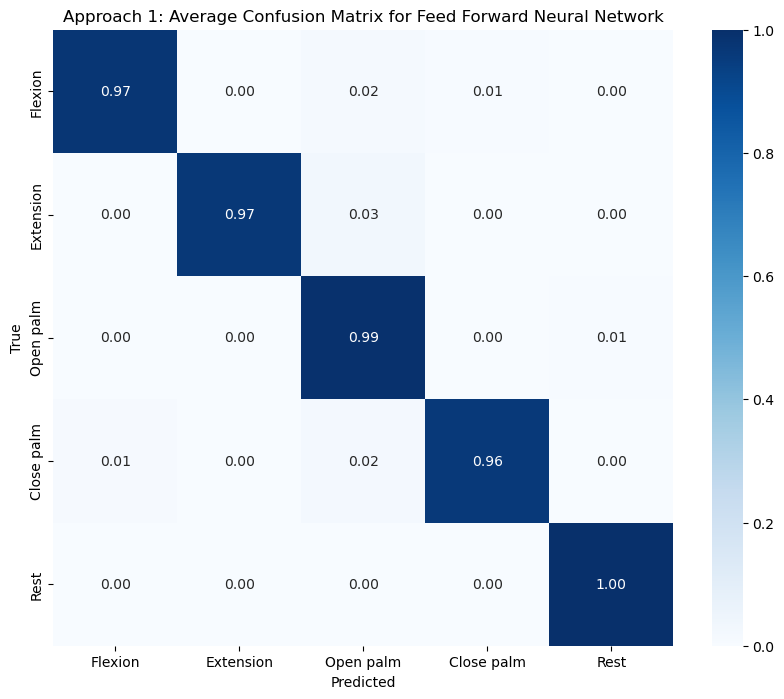

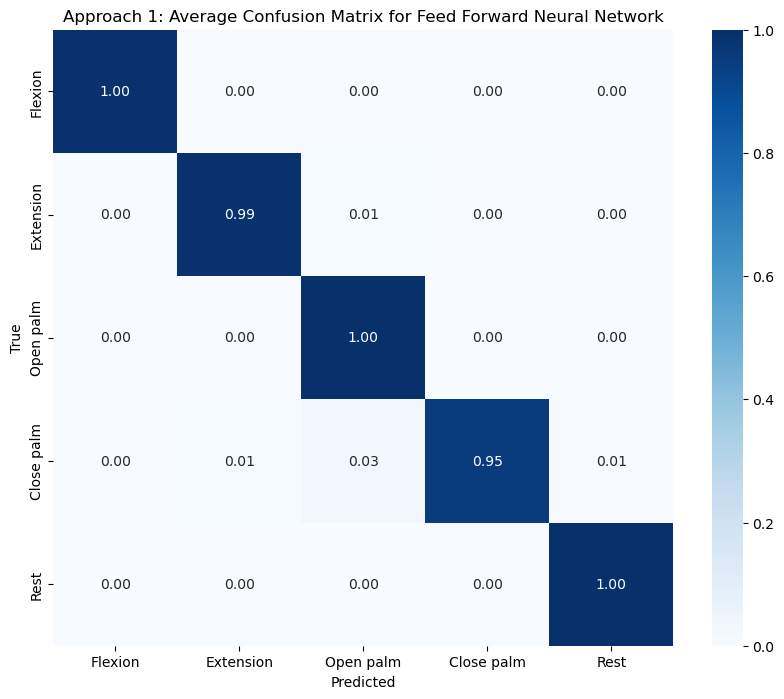

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define class names
class_names = ['Flexion', 'Extension',  'Open palm', 'Close palm', 'Rest']
# Initialize variables to accumulate predictions and true labels
conf_matrices_FFNN = []

# Loop through shifts and folds
for shift in range(9):
    all_predictions = []
    all_true_labels = []
    for k_fold in range(3):
        # Load the trained model
        modelWOoperator = FFNN(8, 9)
        modelWOoperator.load_state_dict(torch.load(f"modelwoOperator_fold_{k_fold+1}_shift_{shift}_app1_5motions.pt"))
        modelWOoperator.eval()

        # Prepare the test dataset
        test_shift_dataset = CustomSignalData(get_tensor(X_test[shift][k_fold]), get_tensor(y_test[shift][k_fold]))
        test_shift_loader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)

        with torch.no_grad():
            for inputs, labels,_,_ in test_shift_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                pred = modelWOoperator(inputs)
                predicted = torch.argmax(pred,dim = 1)
                all_predictions.extend(predicted.tolist())
                all_true_labels.extend(labels.tolist())


        # # Evaluate the model and accumulate predictions and true labels
        # predictions, true_labels = clf_predictions(modelWOoperator, test_shift_loader, encoder=None)
        # all_predictions.extend(predictions)
        # all_true_labels.extend(true_labels)
        
    # Calculate the confusion matrix for the current shift
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)
    conf_matrices_FFNN.append(conf_matrix)

    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]

    # Plot the average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Approach 1: Average Confusion Matrix for Feed Forward Neural Network')
    plt.show()



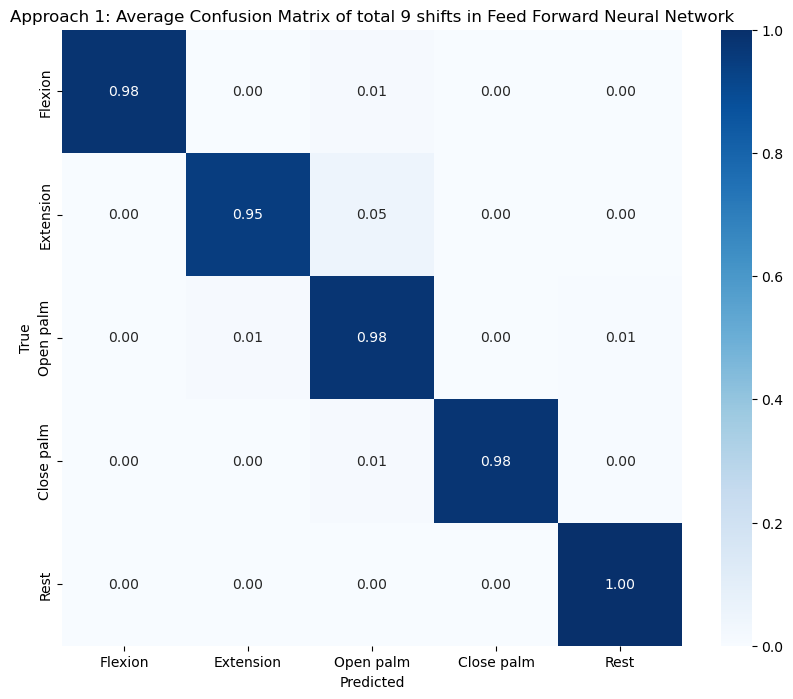

In [7]:
average_conf_matrix_FFNN = np.mean(conf_matrices_FFNN, axis=0)
average_total_samples_per_class_FFNN = np.sum(average_conf_matrix_FFNN, axis=1)
average_conf_matrix_percent_FFNN = average_conf_matrix_FFNN / average_total_samples_per_class_FFNN[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(average_conf_matrix_percent_FFNN, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Approach 1: Average Confusion Matrix of total 9 shifts in Feed Forward Neural Network')
plt.show()

2.4 Self-supervised learning

In [24]:
triplettrainloader_list = [[] for _ in range(9)]

for shift in range(9):
    for k_fold in range(3):
        all_X_train, all_y_train, all_shift_train = get_all_data(X_train[shift][k_fold], y_train[shift][k_fold])
        all_X1_train, all_X2_train, all_shift_1_train, all_shift_2_train, all_y_shift_train = get_shift_data(all_X_train, all_shift_train, all_y_train)

        triplet_train_dataset = CustomSignalData1(get_tensor(all_X1_train), get_tensor(all_X2_train), get_tensor(all_shift_1_train), get_tensor(all_shift_2_train), get_tensor(all_y_shift_train))
        triplettrainloader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size = 102, shuffle=True)
        triplettrainloader_list[shift].append(triplettrainloader)

In [25]:
for triplettrainloader in triplettrainloader_list:
    print(triplettrainloader)

[<torch.utils.data.dataloader.DataLoader object at 0x7fe2278539d0>, <torch.utils.data.dataloader.DataLoader object at 0x7fe22790a710>, <torch.utils.data.dataloader.DataLoader object at 0x7fe2279099c0>]
[<torch.utils.data.dataloader.DataLoader object at 0x7fe22790a860>, <torch.utils.data.dataloader.DataLoader object at 0x7fe2279087f0>, <torch.utils.data.dataloader.DataLoader object at 0x7fe227908a90>]
[<torch.utils.data.dataloader.DataLoader object at 0x7fe2279087c0>, <torch.utils.data.dataloader.DataLoader object at 0x7fe22790b970>, <torch.utils.data.dataloader.DataLoader object at 0x7fe22790b880>]
[<torch.utils.data.dataloader.DataLoader object at 0x7fe22790bc40>, <torch.utils.data.dataloader.DataLoader object at 0x7fe2278a6440>, <torch.utils.data.dataloader.DataLoader object at 0x7fe2278a7820>]
[<torch.utils.data.dataloader.DataLoader object at 0x7fe2278a5fc0>, <torch.utils.data.dataloader.DataLoader object at 0x7fe2278a7520>, <torch.utils.data.dataloader.DataLoader object at 0x7fe22

2.4.2 Training Self-supervised learning

In [26]:
for shift in range(9):
    for k_fold in range(3):
        all_X_train, all_y_train, all_shift_train = get_all_data(X_train[shift][k_fold], y_train[shift][k_fold])

        encoder = E(8,8)
        encoder.to(DEVICE)
        classifier = FFNN(8,9)
        classifier.to(DEVICE)

        parameters = list(encoder.parameters()) + list(classifier.parameters())

        crit1 = torch.nn.MSELoss()
        crit2 = torch.nn.CrossEntropyLoss()
        crit1.to(DEVICE)
        crit2.to(DEVICE)
        loss_record = []

        optimizer = torch.optim.Adam(parameters, lr=0.002)
        n_epochs = 50

        for epoch in range(0,n_epochs):
            encoder.train()
            classifier.train()
            for inputs1, inputs2, shift1, shift2, labels, _ in triplettrainloader_list[shift][k_fold]:
                inputs1 = inputs1.to(DEVICE)
                inputs2 = inputs2.to(DEVICE)
                shift1 = -shift1.int().flatten().to(DEVICE)
                shift2 = -shift2.int().flatten().to(DEVICE)
                labels = labels.long().flatten().to(DEVICE)
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward + backward + optimize
                y1 = encoder(inputs1)
                y_tr_est1 = rotate_batch(y1,shift1,6)
                y_tr1 = classifier(y_tr_est1)


                y2 = encoder(inputs2)
                y_tr_est2 = rotate_batch(y2,shift2,6)
                y_tr2 = classifier(y_tr_est2)

                loss =  crit1(y_tr_est1, y_tr_est2) + 0.5*crit2(y_tr1,labels)+ 0.5*crit2(y_tr2,labels)
                loss.backward()
                optimizer.step()

        torch.save(classifier.state_dict(), f"classifier_fold_{k_fold+1}_shift_{shift}_app1_5motions.pt")
        torch.save(encoder.state_dict(), f"encoder_fold_{k_fold+1}_shift_{shift}_app1_5motions.pt")
        with torch.no_grad():
            encoder.eval()
            N_points = 1000
            rand_idx = np.random.choice(all_X_train.shape[0], N_points)
            y_tr = encoder(get_tensor(all_X_train[rand_idx]))
            recovered_points_ = rotate_batch(y_tr,-all_shift_train[rand_idx].flatten(), 6)
            del y_tr

        torch.save(recovered_points_, f"reference_points_fold_{k_fold+1}_shift_{shift}_app1_5motions.pt")

2.4.3 Testing accuracy of SElf-supervised learning

In [8]:
DEVICE = torch.device("cpu") # operations is in CPU or GPU.
M = torch.diag(torch.ones(8)).roll(-1,1) # Create a diagnoise matrix then shift it to the right
used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)] #

N_points = 1000

accuracies_self_supervised_list = [[0 for _ in range(3)] for _ in range(9)]

for shift in range(9):
    for k_fold in range(3):
        classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
        encoder = E(8,8)
        encoder.load_state_dict(torch.load(f"encoder_fold_{k_fold+1}_shift_{shift}_app1_5motions.pt")) # contains the learned parameters (weights and biases) of the encoder model
        recovered_points_= torch.load(f"reference_points_fold_{k_fold+1}_shift_{shift}_app1_5motions.pt") # These points represent reference points for inference or evaluation in the model
        classifier.load_state_dict(torch.load(f"classifier_fold_{k_fold+1}_shift_{shift}_app1_5motions.pt")) # contains the weights and biases learned during training.
        classifier.eval() # sets the model to evaluation mode.
        encoder.eval() # sets the model to evaluation mode.

        # Get the test data for the current shift and fold
        X_test_shift = X_test[shift][k_fold]

        # Encode the test data using the encoder model
        y1 = encoder(get_tensor(X_test_shift))

        # Use the encoded data directly without rotation
        y_tr1 = classifier(y1).argmax(1)

        # Calculate accuracy and append to list
        accuracies_self_supervised_list[shift][k_fold] = (1 - torch.abs(torch.sign(y_tr1 - get_tensor(y_test[shift][k_fold]).flatten()))).mean().item()
for accuracy in accuracies_self_supervised_list:
    print(accuracy)

[0.9949164986610413, 0.9955817461013794, 0.9576453566551208]
[0.9692533016204834, 0.8007117509841919, 0.972953200340271]
[0.97919762134552, 0.9948071241378784, 0.9939758777618408]
[0.995471715927124, 0.9676691889762878, 0.9788519740104675]
[0.9238020181655884, 0.9915319681167603, 0.9811462759971619]
[0.9828613996505737, 0.9904341697692871, 0.9947878122329712]
[0.997715175151825, 1.0, 1.0]
[0.9766566157341003, 0.9762787222862244, 0.9970171451568604]
[0.9685863852500916, 0.9915579557418823, 0.9946929216384888]


In [9]:
average_accuracies_self_supervised = []
for accuracy in accuracies_self_supervised_list:
    average_accuracies_self_supervised.append(sum(accuracy)/3)

print(average_accuracies_self_supervised)

[0.9827145338058472, 0.9143060843149821, 0.9893268744150797, 0.9806642929712931, 0.9654934207598368, 0.9893611272176107, 0.999238391717275, 0.983317494392395, 0.9849457542101542]


In [10]:
value_average_accuracies_self_supervised = sum(average_accuracies_self_supervised) / 9 
print(value_average_accuracies_self_supervised)

0.9765964415338302


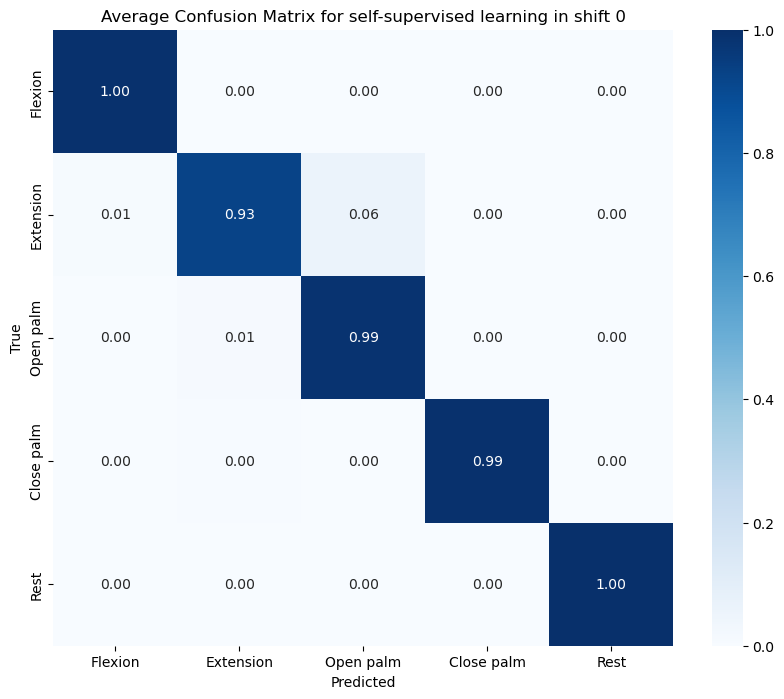

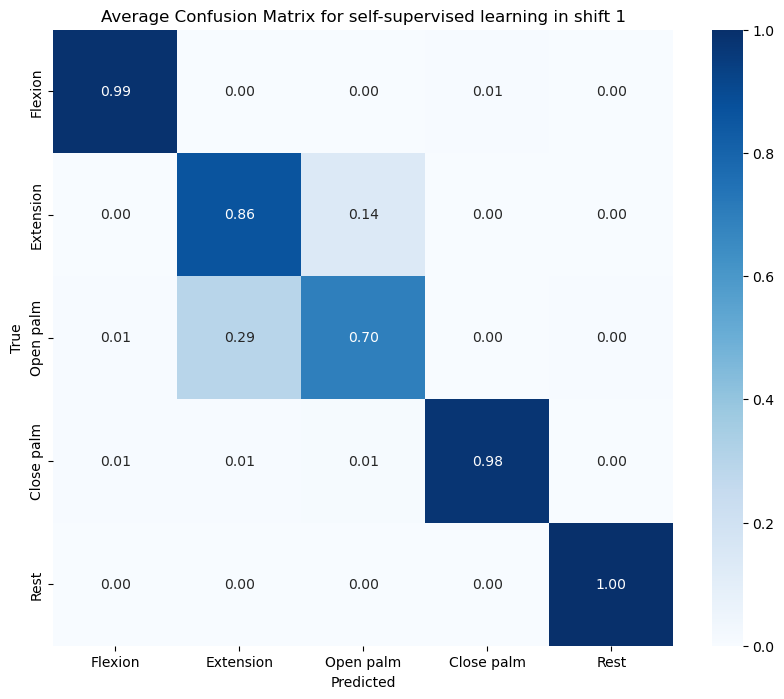

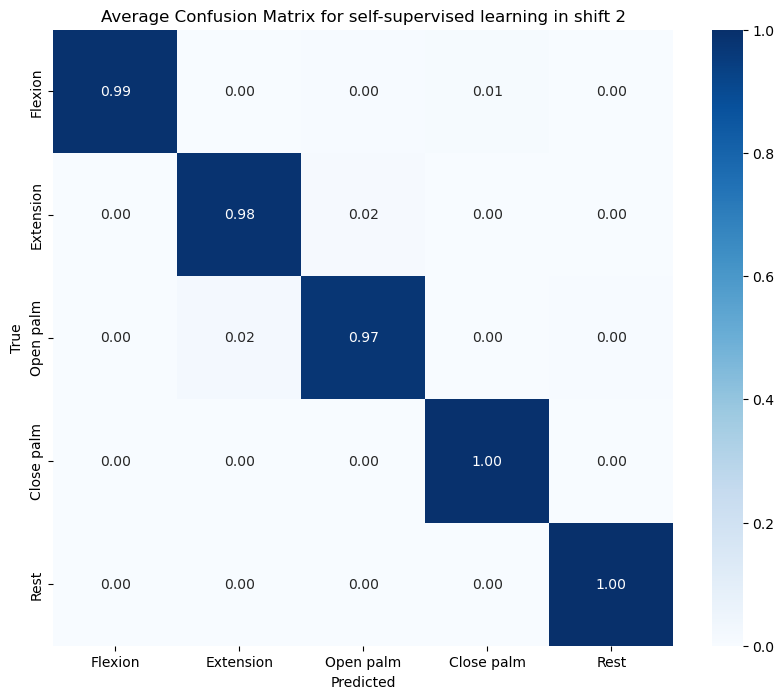

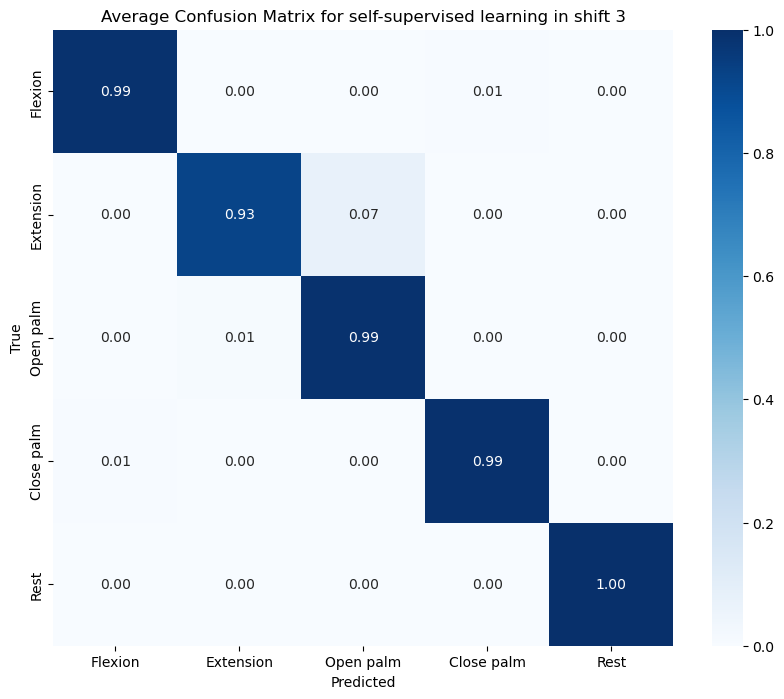

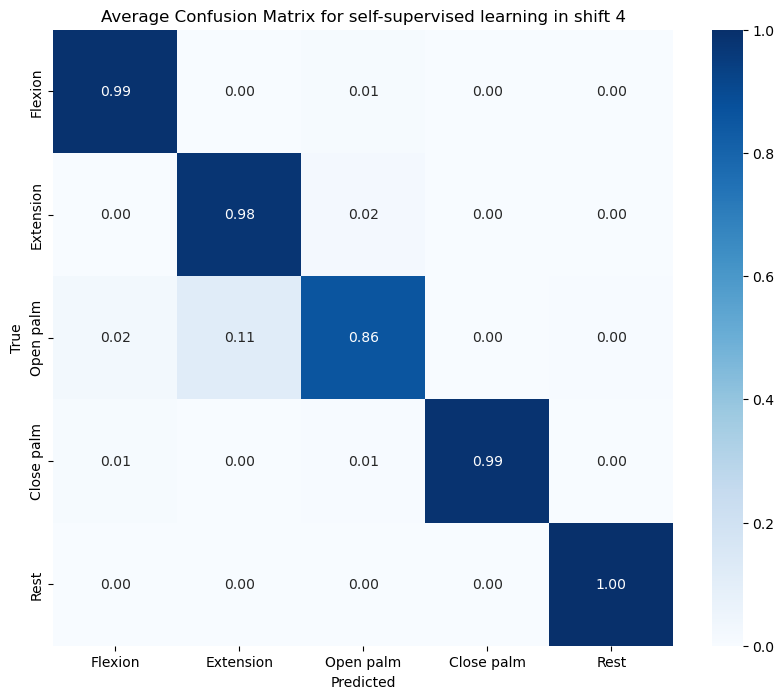

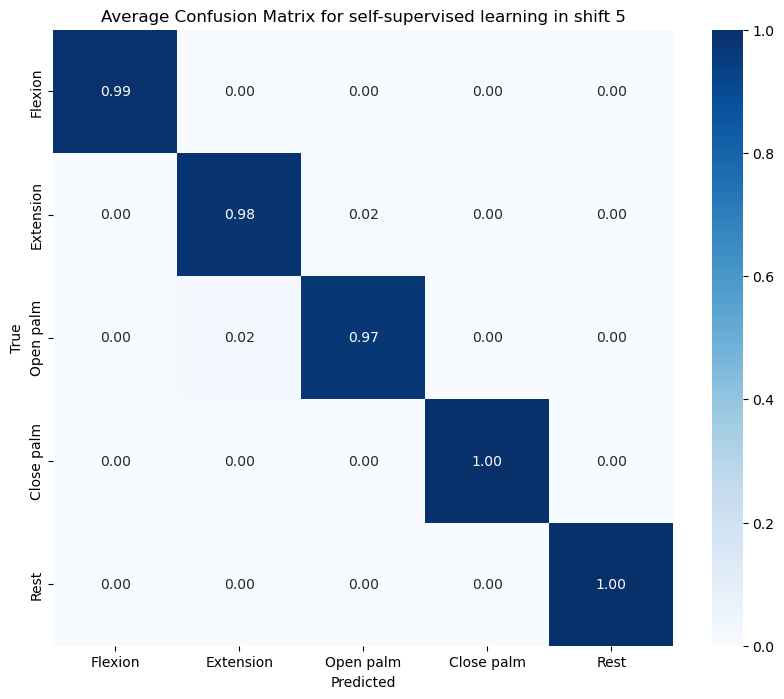

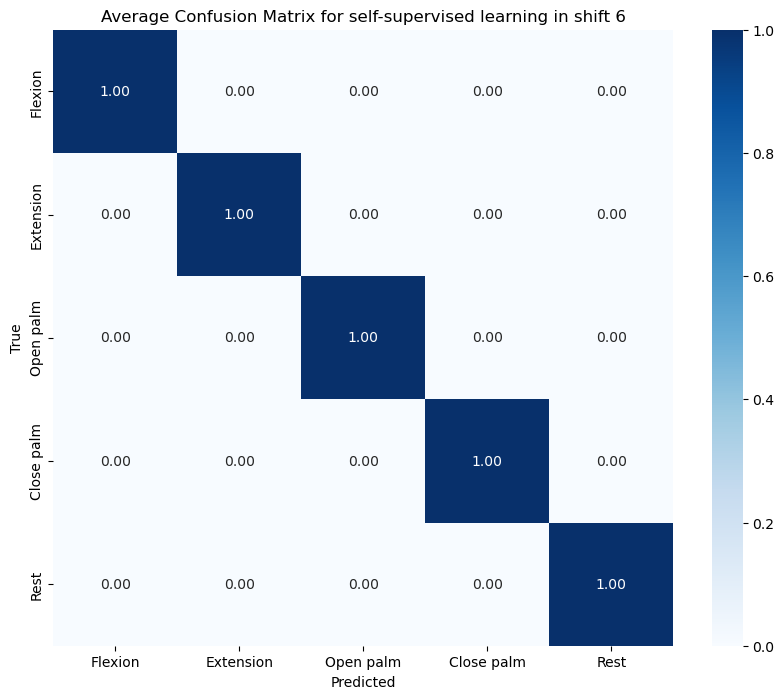

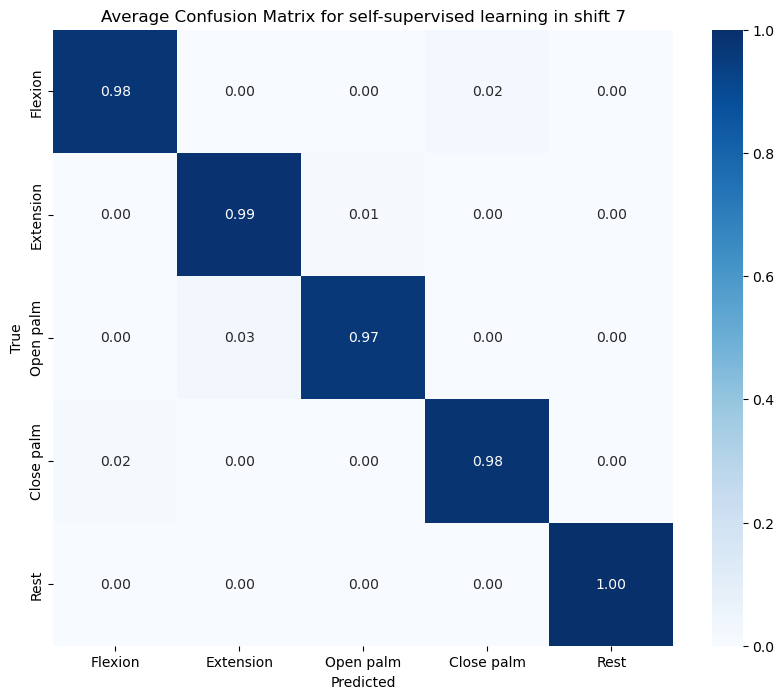

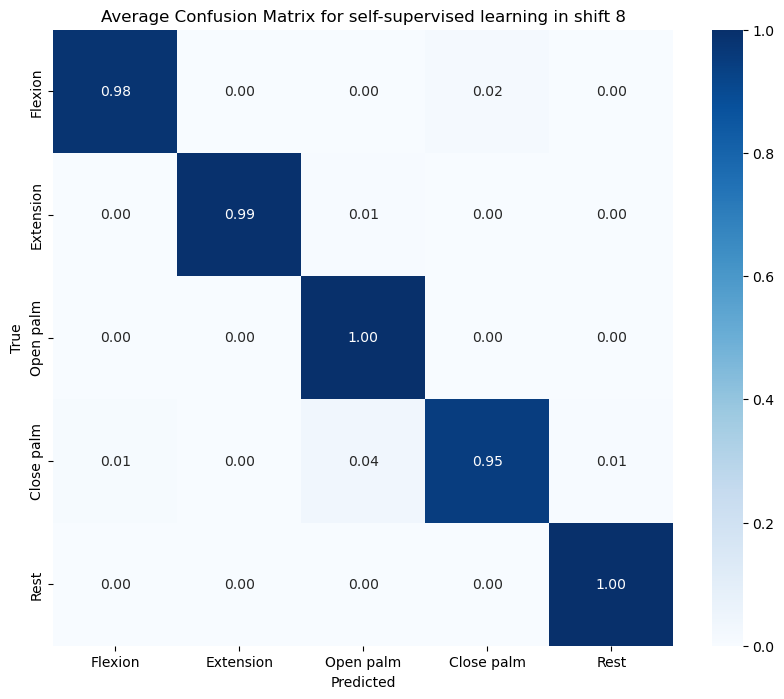

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize variables to accumulate predictions and true labels
conf_matrices_self_supervised = []
class_names = ['Flexion', 'Extension', 'Open palm', 'Close palm', 'Rest']
# Loop through shifts and folds
for shift in range(9):
    all_predictions = []
    all_true_labels = []
    for k_fold in range(3):
        #classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
        encoder = E(8,8)
        encoder.load_state_dict(torch.load(f"encoder_fold_{k_fold+1}_shift_{shift}_app1_5motions.pt")) # contains the learned parameters (weights and biases) of the encoder model
        recovered_points_= torch.load(f"reference_points_fold_{k_fold+1}_shift_{shift}_app1_5motions.pt") # These points represent reference points for inference or evaluation in the model
        classifier.load_state_dict(torch.load(f"classifier_fold_{k_fold+1}_shift_{shift}_app1_5motions.pt")) # contains the weights and biases learned during training.
        classifier.eval() # sets the model to evaluation mode.
        encoder.eval() # sets the model to evaluation mode.

        # Get the test data for the current shift and fold
        X_test_shift = X_test[shift][k_fold]
        # Encode the test data using the encoder model
        y1 = encoder(get_tensor(X_test_shift))
        # Use the encoded data directly without rotation
        y_tr1 = classifier(y1).argmax(1)

        all_predictions.extend(y_tr1.cpu().numpy())
        all_true_labels.extend(get_tensor(y_test[shift][k_fold]).flatten())

        
    # Calculate the confusion matrix for the current shift
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)
    conf_matrices_self_supervised.append(conf_matrix)

    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]


    # Plot the average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Average Confusion Matrix for self-supervised learning in shift {shift}')
    plt.show()

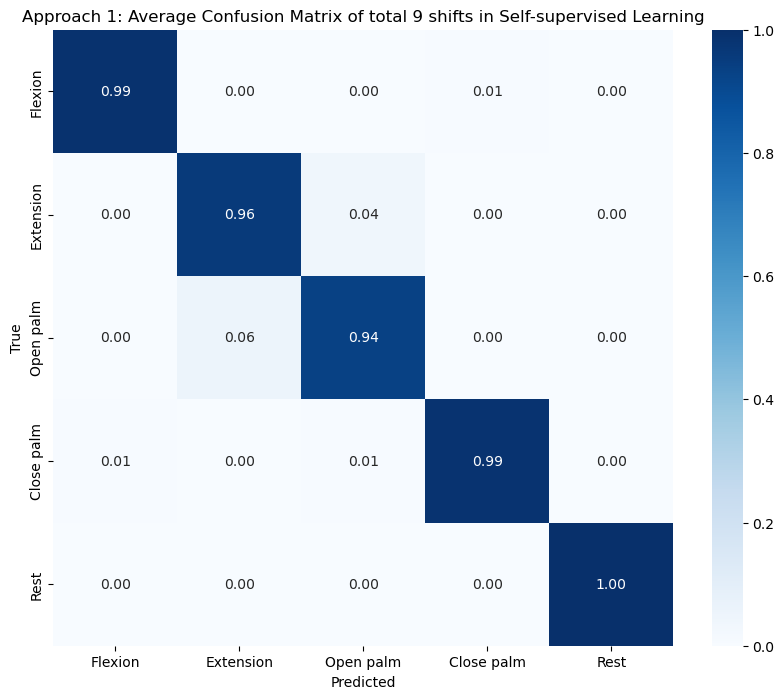

In [12]:

average_conf_matrix__self_supervised = np.mean(conf_matrices_self_supervised, axis=0)
average_total__self_supervised_samples_per_class = np.sum(average_conf_matrix__self_supervised, axis=1)
average_conf__self_supervised_matrix_percent = average_conf_matrix__self_supervised / average_total__self_supervised_samples_per_class[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(average_conf__self_supervised_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Approach 1: Average Confusion Matrix of total 9 shifts in Self-supervised Learning')
plt.show()

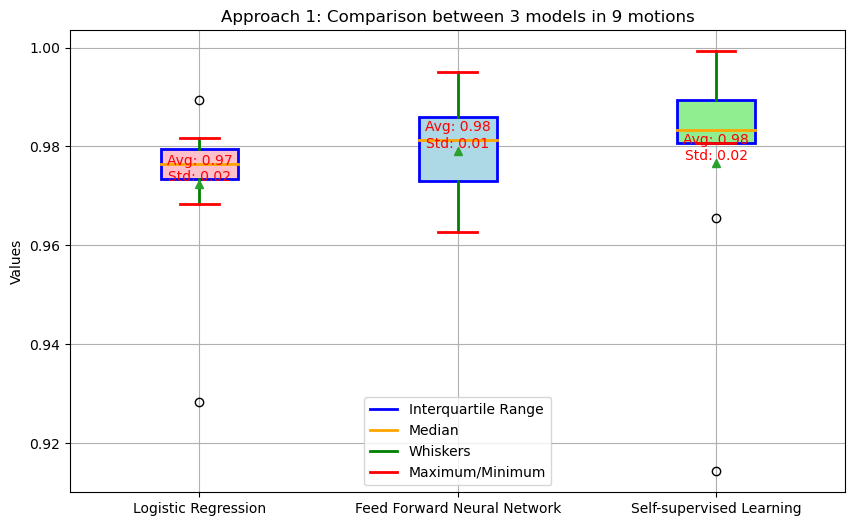

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = [
    [0.9684179721674316, 0.9283976502658297, 0.9756579835419649, 0.9781372015800202, 0.9794027065516273, 0.9765257017782872, 0.9893189814784379, 0.9733728950824684, 0.9816132965743084],
    [0.962733606947872, 0.9640843868255615, 0.9804110913385724, 0.9818948361845243, 0.9860020467413911, 0.9730744428167069, 0.9949494925412266, 0.9812458932723418, 0.9879915191304116],
    [0.9827145338058472, 0.9143060843149821, 0.9893268744150797, 0.9806642929712931, 0.9654934207598368, 0.9893611272176107, 0.999238391717275, 0.983317494392395, 0.9849457542101542]
]

# Calculate average and standard deviation
averages = [np.mean(lst) for lst in data]
std_devs = [np.std(lst) for lst in data]

# Plot boxplot with customized colors and statistics
plt.figure(figsize=(10, 6))
colors = ['pink', 'lightblue', 'lightgreen']
boxprops = dict(color="blue", linewidth=2)
medianprops = dict(color="orange", linewidth=2)
whiskerprops = dict(color="green", linewidth=2)
capprops = dict(color="red", linewidth=2)
box = plt.boxplot(data, showmeans=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)


plt.xticks([1, 2, 3], ['Logistic Regression', 'Feed Forward Neural Network', 'Self-supervised Learning'])
plt.ylabel('Values')
plt.title('Approach 1: Comparison between 3 models in 9 motions')
plt.grid(True)

# Add average and standard deviation text
for i in range(len(data)):
    plt.text(i + 1, averages[i], f'Avg: {averages[i]:.2f}\nStd: {std_devs[i]:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

# Add legend explaining box components
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Interquartile Range'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Median'),
    plt.Line2D([0], [0], color='green', lw=2, label='Whiskers'),
    plt.Line2D([0], [0], color='red', lw=2, label='Maximum/Minimum')
]
plt.legend(handles=legend_elements)

plt.show()
